## Qantas Data Engineer Challenge

### Problem Statement

### Data Set : 

This is a public dataset that contains data about 51,566 pubs in England. Pubs, or public houses, is an establishment licensed to sell alocholic drinks and food. It's a social drinking establishment and a prominent part of British, Irish, New Zealand, Canadian, South African and Australian cultures. In many places, especially in villages, a pub is the focal point of the community.

##### Format : csv 
##### Columns

1. fsa_id (int): Food Standard Agency's ID for this pub.
2. name (string): Name of the pub
3. address (string): Address fields separated by commas.
4. postcode (string): Postcode of the pub.
5. easting (int)
6. northing (int)
7. latitude (decimal)
8. longitude (decimal)
9. local_authority (string): Local authority this pub falls under.


##### Data Engineer Questions

Write clean Pyspark code to answer any two of the following questions. 

1. Please refrain from using embedded queries in the code. Pyspark.sql.functions is preferred over sql queries.
2. Proper comments and unit test cases are appreciated.
3. Share the output data & the code via a github repo.

#### Questions

1. Which is the most isolated pub in England ?
2. Which local_authority has the least number of pubs?
3. Which 5 words are the most common words used in the English pub names ?
4. Which Street in England has the highest number of pubs?


### Data Cleansing Steps:

1. Some of the rows (roughly 10) has the latitude and longitude information as '\\N' and it is filtered.
2. Some of the latitude and longitude information are invalid.

In [78]:
## Imports
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import geopy.distance

# SparkSession and Log4j initialization
spark = SparkSession.builder.appName("QantasDataEngineering").getOrCreate()
log4jLogger = spark._jvm.org.apache.log4j
log = log4jLogger.LogManager.getLogger(__name__)

# Utility method to get the distance from center in miles for the latitude and longitude coordinates provided
def getGeoDistanceFromLeicester(coords):
        try:
            coordslat,coordslong = coords.split(",")
            coordsRefined = (float(coordslat), float(coordslong))
            print(coordsRefined)
            england_center_lat = 52.6369
            england_center_long = 1.1398
            england_center_coords = (england_center_lat, england_center_long)
            return geopy.distance.distance(england_center_coords, coordsRefined).miles
        except ValueError:
            return 0.0

# Register the function as udf in spark to use later
geoUdf = udf(getGeoDistanceFromLeicester)    
        
class PubsDataAnalyzer:
#   Method to load pubs data based on the passed file. The default format is csv.
    def loadPubsData(self, filePath, format = "csv"):
        log.info(f"loading Pub Info from ${filePath}")
        pubsData = spark.read.format(format).options(header="true", inferSchema="true").option("quote", "\"").option("escape", "\"").load(filePath)
        log.info(f"Finished loading Pub Info from ${filePath}")
        return pubsData
    
#   Method that cleanse the data set by removing some invalid characters for latitude longitude field and adding 
#   a way to calculate the distance from the center using the registered udf function.
    def getCleansedAndModifiedPubsData(self,dataset):
        pubsData = self.loadPubsData(dataset)
        pubsDataConcatenated = pubsData.withColumn("lat_long", concat_ws(",", pubsData.latitude, pubsData.longitude))
        pubsDataCleansed = pubsDataConcatenated.filter(pubsDataConcatenated.lat_long != '\\N,\\N')
        pubsDataCleansedAndModified = pubsDataCleansed.withColumn("distance", geoUdf(pubsDataConcatenated.lat_long))
        pubsDataCleansedAndModified = pubsDataCleansedAndModified.withColumn("distance", pubsDataCleansedAndModified.distance.cast(FloatType()))
        return pubsDataCleansedAndModified

In [79]:
# Instantiate PubsDataAnalyzer and call the method getCleansedAndModifiedPubsData with file path.
filePath = "<path-to-the-file>/pubs_in_england.csv"
pubsDataModified=PubsDataAnalyzer().getCleansedAndModifiedPubsData(filePath)

In [80]:
pubsDataModified.count()

51496

In [102]:
# Sample Data
pubsDataModified.take(5)

[Row(fas_id='24', name='Anchor Inn', address='Upper Street, Stratford St Mary, COLCHESTER, Essex', postcode='CO7 6LW', easting='604748', northing='234405', latitude='51.97039', longitude='0.979328', local_authority='Babergh', lat_long='51.97039,0.979328', distance=46.582969665527344),
 Row(fas_id='30', name='Angel Inn', address='Egremont Street, Glemsford, SUDBURY, Suffolk', postcode='CO10 7SA', easting='582888', northing='247368', latitude='52.094427', longitude='0.668408', local_authority='Babergh', lat_long='52.094427,0.668408', distance=42.484336853027344),
 Row(fas_id='63', name='Black Boy Hotel', address='7 Market Hill, SUDBURY, Suffolk', postcode='CO10 2EA', easting='587356', northing='241327', latitude='52.038683', longitude='0.730226', local_authority='Babergh', lat_long='52.038683,0.730226', distance=44.85206985473633),
 Row(fas_id='64', name='Black Horse', address='Lower Street, Stratford St Mary, COLCHESTER, Essex', postcode='CO7 6JS', easting='604270', northing='233920', l

### 1. Which is the most isolated pub in England ?

The data set provided contains all the pub information in UK as a whole. I have tried to come up with the hypothesis to locate the geographical center of England and calculate how much distance each of the pub is from the center. By doing that calculation #### "Ness F C Social Club" seems to be the farthest in UK with 497 miles away from center.

In [81]:
# Maximum distance is calculated from the center to identify the most isolated pub.
# The location of the pub in the map below indeed confirms that it is isolated from the center.
max_distance = pubsDataModified.groupBy().agg(max('distance').alias('max_distance')).collect()[0].max_distance
pubsDataIsolated = pubsDataModified.filter(pubsDataModified.distance == max_distance)
pubsDataIsolated.collect()

[Row(fas_id='445339', name='Ness F C Social Club', address='Social Club, Fivepenny, Ness, Isle Of Lewis', postcode='HS2 0XB', easting='152853', northing='963481', latitude='58.489238', longitude='-6.242496', local_authority='Na h-Eileanan Siar', lat_long='58.489238,-6.242496', distance=497.05377197265625)]

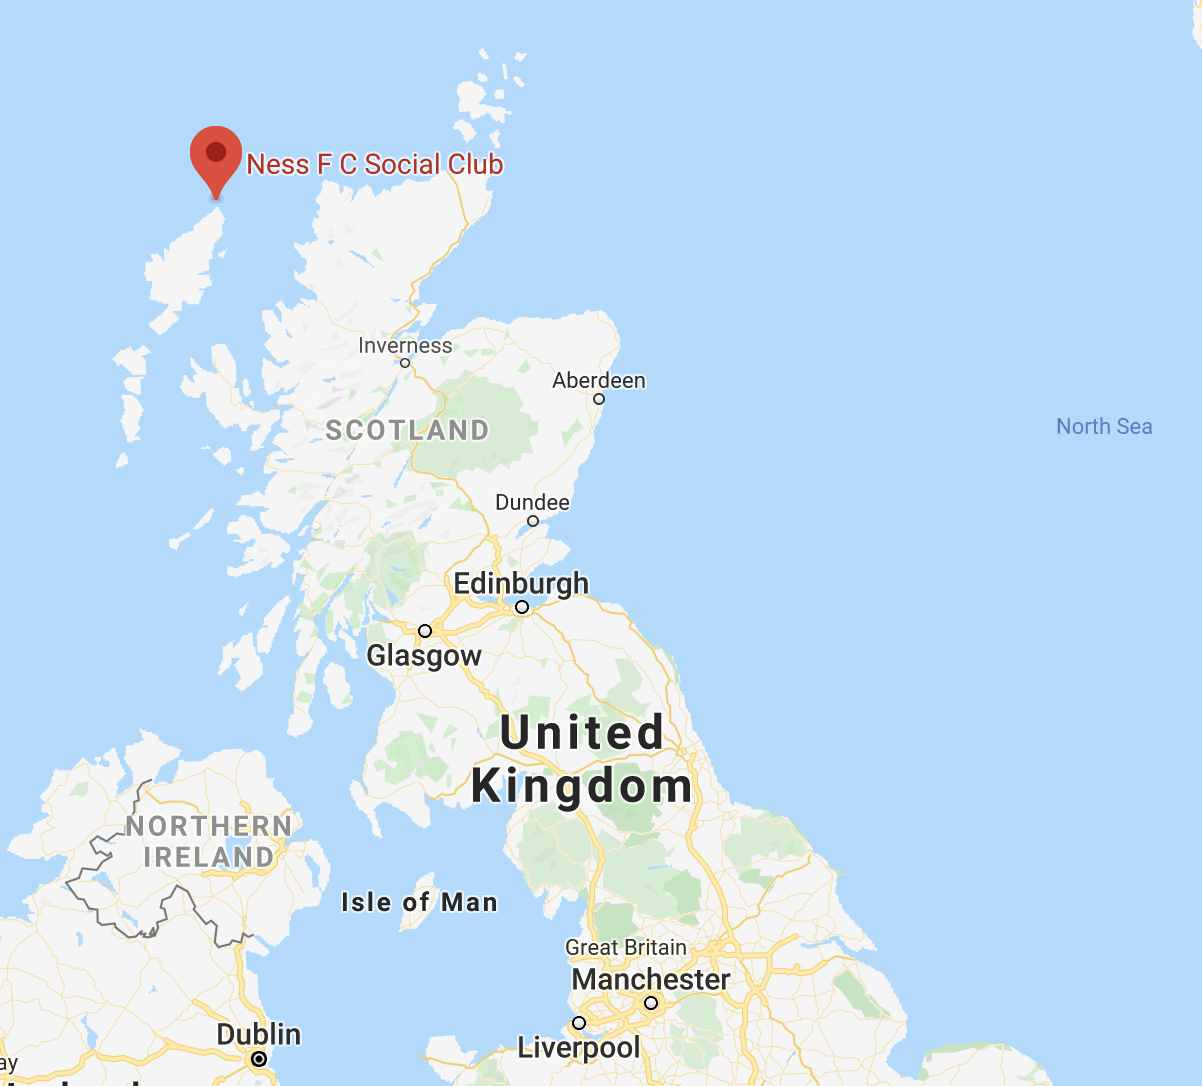

#### There are totally 9 pubs in the given dataset with England in their address

In [82]:
# Tried to do regex match on England in address field to get the list of records corresponding to England.
pubsInEngland = pubsDataModified.filter(pubsDataModified.address.rlike('.*England.*')).collect()
len(pubsInEngland)

9

### 2. Which Local Authority has Least Number of Pubs??

In [85]:
# Aggregate by Local Authority and take the minimum by ordering by number of pubs and taking the 1st one in the result
noOfPubsByLocalAuthority = pubsDataModified.groupBy('local_authority').agg(count('fas_id').alias('no_of_pubs')).orderBy('no_of_pubs').limit(1)
noOfPubsByLocalAuthority.collect()

[Row(local_authority='Tower Hamlets', no_of_pubs=1)]

#### From the above result, the local authority with minimum number of pubs is Tower Hamlets with 1 Pub

### 3. Which 5 words are the most common words used in the English pub names ?

In [86]:
# Declare a set of words that are coming up in top ten but those are stop words.
# Split based on the name of the pub and explore to separate rows for us to be able to group by and do the count.

rejectWordList = ['The', '&', 'And', 'and']
pubNameCountSorted = pubsDataModified.select(explode(split(pubsDataModified.name," ")).alias('name')).groupBy('name').count().sort('count', ascending=False)
pubNameCountSorted.filter(~pubNameCountSorted.name.isin(rejectWordList)).limit(5).collect()

[Row(name='Club', count=9395),
 Row(name='Inn', count=7131),
 Row(name='Arms', count=3049),
 Row(name='Bar', count=2319),
 Row(name='House', count=2131)]

#### Top 5 common words used in English Pub Names is shown above.

### 4. Which Street in England has the highest number of pubs?

In [87]:
# The address column is split based on "," and then the first portion which is the street name is taken and then grouped 
# based on the streets. The count of pubs is extracted and the highest one in terms of number of pubs is returned.
pubsDataStreetWithHighestPubs = pubsDataModified.select(split(pubsDataModified.address,",")[0].alias('streets')).groupBy('streets').count().sort('count', ascending=False)
pubsDataStreetWithHighestPubs.limit(1).collect()

[Row(streets='High Street', count=473)]

### Unit Test

Unit Test Cases are written to test the overall sanity of the dataset. The test validates the input file and the functionality of the class. The tests also look for any data integrity gaps that may require specific cleansing that needs to be done before the processing.



In [113]:
import unittest

class TestQuantasDataEngineer(unittest.TestCase):
    
    def setUp(self):
        file = "<path-to-the-file>/pubs_in_england.csv"
        self.file = file
        self.pubsData=PubsDataAnalyzer().loadPubsData(file)
        self.pubsDataMod=PubsDataAnalyzer().getCleansedAndModifiedPubsData(filePath)
        
    def test_count_of_records(self):
        count_of_records=51566
        self.assertEqual(self.pubsData.count(), count_of_records)
        
    def test_modified_count_of_records(self):
        count_of_records=51496
        self.assertEqual(self.pubsDataMod.count(), count_of_records)
        
    def test_count_of_distinct_local_authorities(self):
        count_of_distinct_local_authorities=376
        self.assertEqual(self.pubsDataMod.select('local_authority').distinct().count(), count_of_distinct_local_authorities)
        
    def test_check_valid_fas_id(self):
        self.assertEqual(self.pubsDataMod.select('fas_id').filter("fas_id == ''").count(), 0)
        
    def test_check_match_count_fas_id(self):
        count_of_records=51496
        self.assertEqual(self.pubsDataMod.select('fas_id').distinct().count(),count_of_records)

if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit=False)
#     unittest.main()
        
# 

test (__main__.MyTest) ... ok
test_check_match_count_fas_id (__main__.TestQuantasDataEngineer) ... ok
test_check_valid_fas_id (__main__.TestQuantasDataEngineer) ... ok
test_count_of_distinct_local_authorities (__main__.TestQuantasDataEngineer) ... ok
test_count_of_records (__main__.TestQuantasDataEngineer) ... ok
test_modified_count_of_records (__main__.TestQuantasDataEngineer) ... ok
test_isupper (__main__.TestStringMethods) ... ok
test_upper (__main__.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 8 tests in 6.278s

OK
